In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:50% !important; }</style>"))

In [2]:
import inspect
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(font_scale=3, style="ticks")

# Задача 1. Гистограмная оценка плотности

In [3]:
import scipy
import scipy.stats
from scipy import stats
import sklearn
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import KFold, train_test_split

 Для выбора оптимальной ширины бина нужно найти минимум эмпирического риска:

\begin{gather*}
J(h) = \int \hat{p}^2(x) dx - 2 \int \hat{p}(x) p(x) dx
\end{gather*}

Т.к. пространство у нас дискретное, то можно применить Leave-One-Out кросс-валидацию для оценки эмпирическоого риска:


\begin{gather*}
\hat{J}(h) = \frac{2}{(n - 1)h} - \frac{n+1}{(n-1)h}\sum_{j = 1}^m \hat{p}_j^2,\quad \hat{p}_j = \frac{n_j}{n}.
\end{gather*}

### Выбор оптимальной ширины бинов

In [4]:
seed = 1
n_samples = 100
gen1 = scipy.stats.norm(loc=0, scale=1)
gen2 = scipy.stats.norm(loc=5, scale=1)
p1 = 0.3
p2 = 1 - p1
samples1 = gen1.rvs(size=int(p1 * n_samples), random_state=seed)       # Samples from the first components
samples2 = gen2.rvs(size=int(p2 * n_samples), random_state=seed + 1)   # Samples from the second components
samples = np.concatenate([samples1, samples2])                         # All samples

x_values = np.linspace(-5, 10, 1000)
binedges = np.linspace(-5, 10, 10)
true_pdf = p1 * gen1.pdf(x_values) + p2 * gen2.pdf(x_values)

In [5]:
def create_binedges(center, bandwidth, x_left, x_right):
    """
    Функция для создания массива краёв бинов. 
    На вход приходит центр, ширина бина, левый край и правый край.
    """
    h = bandwidth
    bins = [center - h / 2]
    while x_left < bins[-1]:
        bins.append(bins[-1] - h)
    bins = list(reversed(bins))
    while x_right > bins[-1]:
        bins.append(bins[-1] + h)
    return bins

In [6]:
def histogram_pdf_estimated_risk(bincounts, h):
    """
    Функция оценки эмпирического 
    """
    n = np.sum(bincounts)
    ps = bincounts / n
    J = 2 / ((n - 1) * h) - ((n + 1.0) / (h * (n - 1.0))) * np.sum(ps ** 2)
    return J

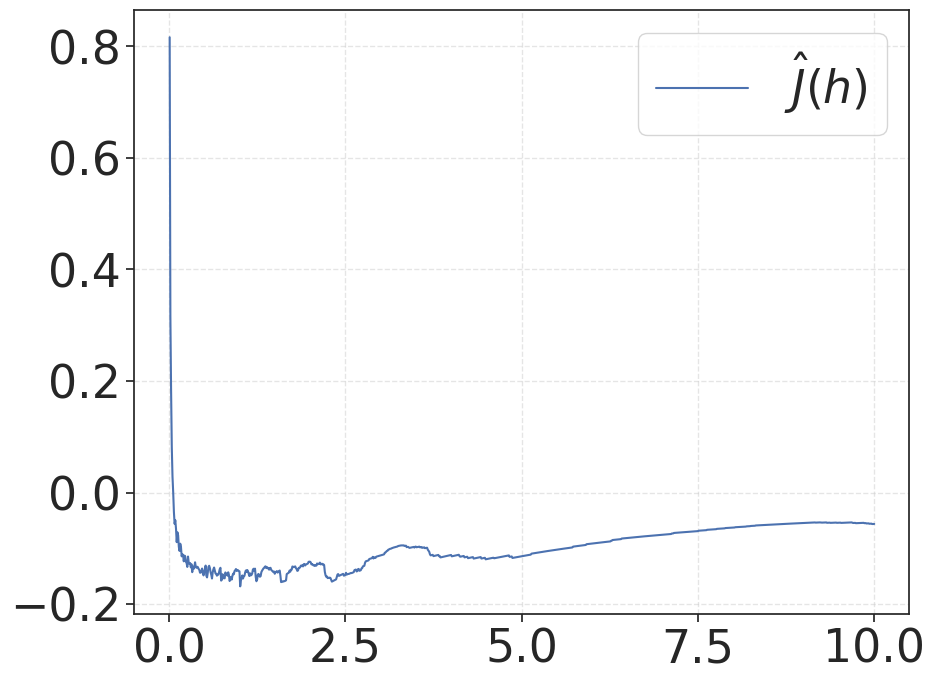

In [7]:
bandwidth_range = np.linspace(0.01, 10, 1000)
risk_values = []
for bandwidth in bandwidth_range:
    binedges = create_binedges(0, bandwidth, samples.min(), samples.max())
    bincounts, _ = np.histogram(samples, bins=binedges)
    risk_values.append(histogram_pdf_estimated_risk(bincounts, bandwidth))
risk_values = np.array(risk_values)

plt.figure(figsize=(10, 8), dpi=100)
plt.plot(bandwidth_range, risk_values, color='b', label=r'$\hat{J}(h)$', zorder=2);
plt.legend();
plt.grid(which='both', linestyle='--', alpha=0.5);
plt.show()

In [8]:
index_min = np.argmin(risk_values)
opt_bandwidth = bandwidth_range[index_min]
min_risk = risk_values[index_min]
print('h = {}, J = {}'.format(opt_bandwidth, min_risk))

h = 1.01, J = -0.16828082808280825


### PDF для оптимальной ширины ядра

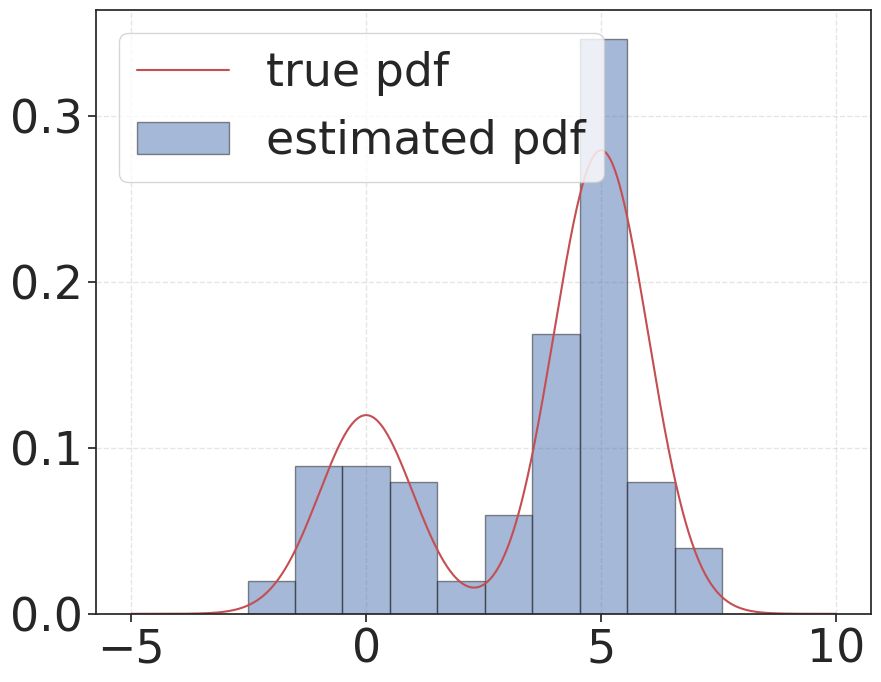

In [9]:
binedges = create_binedges(0, opt_bandwidth, samples.min(), samples.max())
plt.figure(figsize=(10, 8), dpi=100)
plt.hist(samples, bins=binedges, color='b', density=True, edgecolor='k', 
         label='estimated pdf', alpha=0.5, zorder=2);
plt.plot(x_values, true_pdf, color='r', label='true pdf', zorder=2);
plt.legend();
plt.grid(which='both', linestyle='--', alpha=0.5);
plt.show()

# Задача 2. Ядерная оценка плотности

\begin{gather*}
MISE = \frac{1}{4} \sigma_K^4 h^4 \int (p''(x))^2 dx + \frac{1}{nh} \int \left( K(x) \right)^2 dx
\end{gather*}

**Что оказывает наибольшее влияние на качество оценки ядерной плотностью?**

При вычислениях пользуемся оценкой эмпирического риска вида:
\begin{gather*}
\hat{J}(h) = \frac{1}{hn^2}\sum_{i = 1}^n \sum_{j = 1}^n K^{(2)}\left(\frac{x_i - x_j}{h}\right) + \frac{K(0)}{nh},
\end{gather*}
где
\begin{gather*}
K^{(2)}(x) = K^*(x) - 2K(x), \quad K^*(x) = \int K(x - y) K(y) dy.
\end{gather*}

Подробности о формуле выше: http://www.stat.cmu.edu/~larry/=sml/densityestimation.pdf

Далее приводятся примеры [ядерное оценивание плотности из библиотеки sklearn](http://scikit-learn.org/stable/modules/density.html)

In [10]:
def gaussian_kernel_estimated_risk(samples, bandwidth):
    """
    Arguments:
    -samples: 1D numpy array with samples
    -bandwidth: bandwidth parameter of gaussian kernel
    
    Returns estimated risk value.
    """
    X = samples
    h = bandwidth
    n = len(X)
    Jh = 0
    Xi = X[None, :]
    Xj = X[:, None]
    points = (Xi - Xj) / h

    Jh = np.sum(stats.norm.pdf(points, loc=0, scale=np.sqrt(2))) - 2 * np.sum(stats.norm.pdf(points, loc=0, scale=1))
    Jh /= h * (n**2)
    Jh += (2.0 / (h * n)) * stats.norm.pdf(0, loc=0, scale=1)
    return Jh

-4.386187161995823 9.555607673750231 9.294529890497369


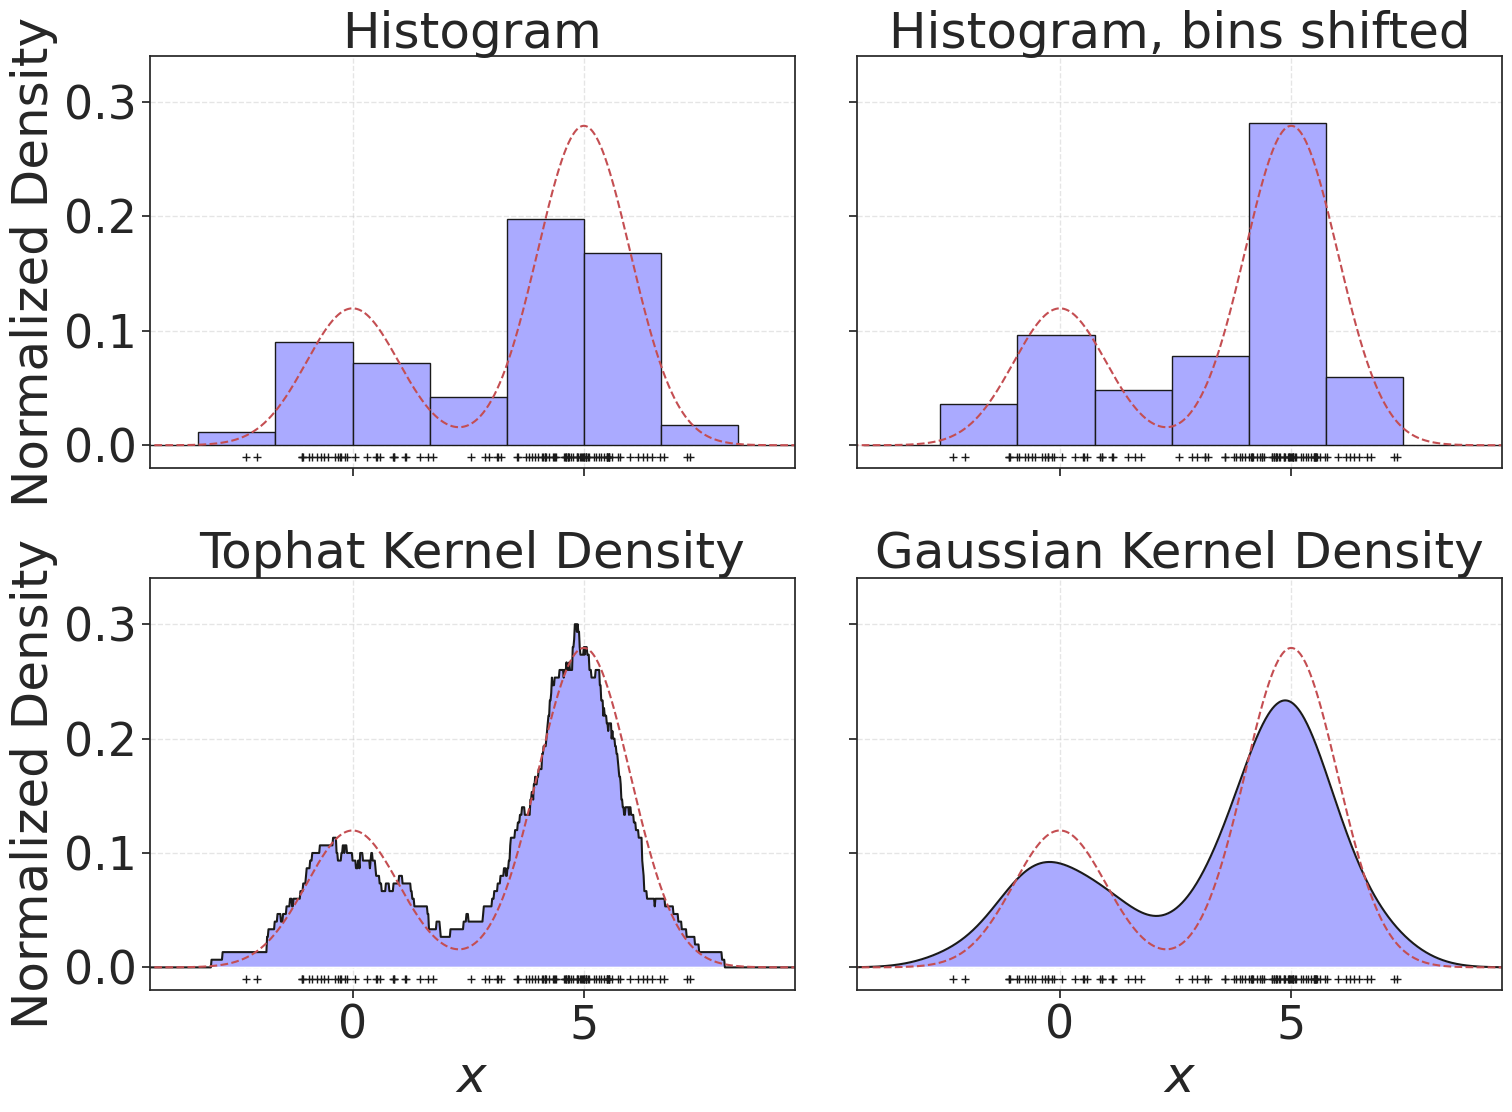

In [11]:
from itertools import product

seed = 1
n_samples = 100
gen1 = scipy.stats.norm(loc=0, scale=1)
gen2 = scipy.stats.norm(loc=5, scale=1)
p1 = 0.3
p2 = 1 - p1
samples1 = gen1.rvs(size=int(p1 * n_samples), random_state=seed)       # Samples from the first components
samples2 = gen2.rvs(size=int(p2 * n_samples), random_state=seed + 1)   # Samples from the second components
samples = np.concatenate([samples1, samples2])                         # All samples

alpha = 0.01; gamma = 0.25
x_left = np.percentile(samples, 100 * alpha)
x_right = np.percentile(samples, 100 * (1 - alpha))
x_width = x_right - x_left
x_left  -= gamma * x_width
x_right += gamma * x_width
print(x_left, x_right, x_width)

x_values = np.linspace(-5, 10, 1000)
binedges = np.linspace(-5, 10, 10)
true_pdf = p1 * gen1.pdf(x_values) + p2 * gen2.pdf(x_values)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(16, 12), dpi=100)

# histogram 1
ax[0, 0].hist(samples, bins=binedges, fc='#AAAAFF', density=True, edgecolor='k')
ax[0, 0].set_title("Histogram")

# histogram 2
ax[0, 1].hist(samples, bins=binedges + 0.75, fc='#AAAAFF', density=True, edgecolor='k')
ax[0, 1].set_title("Histogram, bins shifted")

# tophat KDE
kde = KernelDensity(kernel='tophat', bandwidth=0.75).fit(samples[:,None])
log_dens = kde.score_samples(x_values[:,None])
ax[1, 0].plot(x_values, np.exp(log_dens), color='k', zorder=2)
ax[1, 0].fill(x_values, np.exp(log_dens), fc='#AAAAFF', zorder=2)
ax[1, 0].set_title("Tophat Kernel Density")

# Gaussian KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(samples[:,None])
log_dens = kde.score_samples(x_values[:,None])
ax[1, 1].plot(x_values, np.exp(log_dens), color='k', zorder=2)
ax[1, 1].fill(x_values, np.exp(log_dens), fc='#AAAAFF')
ax[1, 1].set_title("Gaussian Kernel Density")

for n_row, n_col in product(range(2), range(2)):
    ax[n_row, n_col].grid(which='both', linestyle='--', alpha=0.5)
    ax[n_row, n_col].plot(x_values, true_pdf, color='r', linestyle='--', zorder=2);
    
for axi in ax.ravel():
    axi.plot(samples, np.zeros(len(samples)) - 0.01, '+k')
    axi.set_xlim(x_left, x_right)
    axi.set_ylim(-0.02, 0.34)

for axi in ax[:, 0]:
    axi.set_ylabel('Normalized Density')

for axi in ax[1, :]:
    axi.set_xlabel('$x$')
    
fig.tight_layout()
plt.show()

## Выбор оптимальной ширины ядра

In [12]:
seed = 1
n_samples = 100
gen1 = scipy.stats.norm(loc=0, scale=1)
gen2 = scipy.stats.norm(loc=5, scale=1)
p1 = 0.3
p2 = 1 - p1
samples1 = gen1.rvs(size=int(p1 * n_samples), random_state=seed)       # Samples from the first components
samples2 = gen2.rvs(size=int(p2 * n_samples), random_state=seed + 1)   # Samples from the second components
samples = np.concatenate([samples1, samples2])                         # All samples

x_values = np.linspace(-5, 10, 1000)
binedges = np.linspace(-5, 10, 10)
true_pdf = p1 * gen1.pdf(x_values) + p2 * gen2.pdf(x_values)

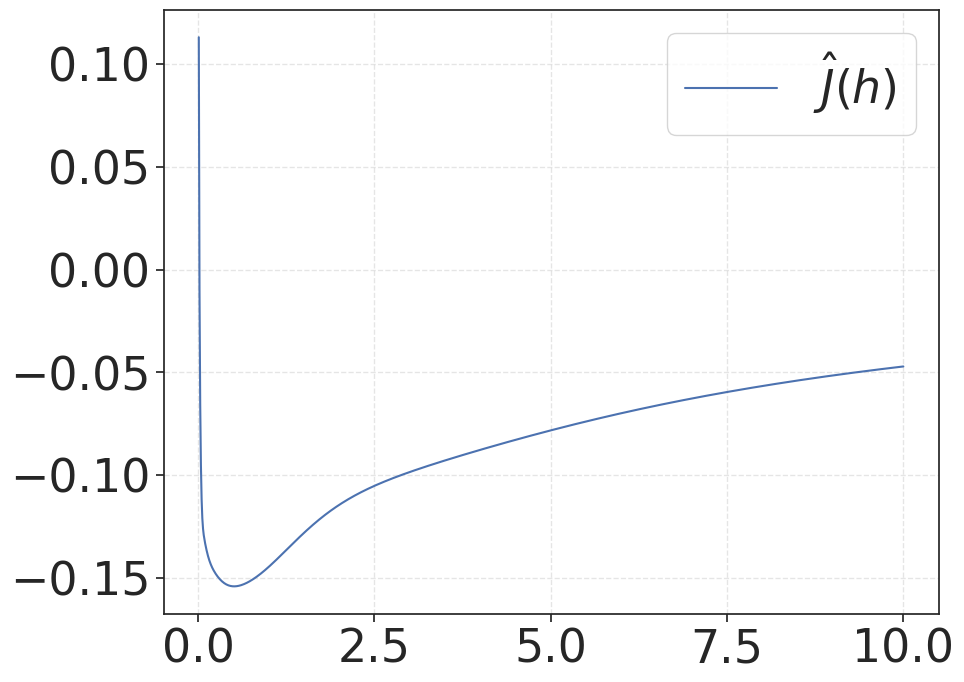

In [13]:
bandwidth_range = np.linspace(0.01, 10, 1000)
risk_values = []
for bandwidth in bandwidth_range:
    risk_values.append(gaussian_kernel_estimated_risk(samples, bandwidth))
risk_values = np.array(risk_values)

plt.figure(figsize=(10, 8), dpi=100)
plt.plot(bandwidth_range, risk_values, color='b', label=r'$\hat{J}(h)$', zorder=2);
plt.legend();
plt.grid(which='both', linestyle='--', alpha=0.5);
plt.show()

In [14]:
index_min = np.argmin(risk_values)
opt_bandwidth = bandwidth_range[index_min]
min_risk = risk_values[index_min]
print('h = {}, J = {}'.format(opt_bandwidth, min_risk))

h = 0.51, J = -0.1541258590473714


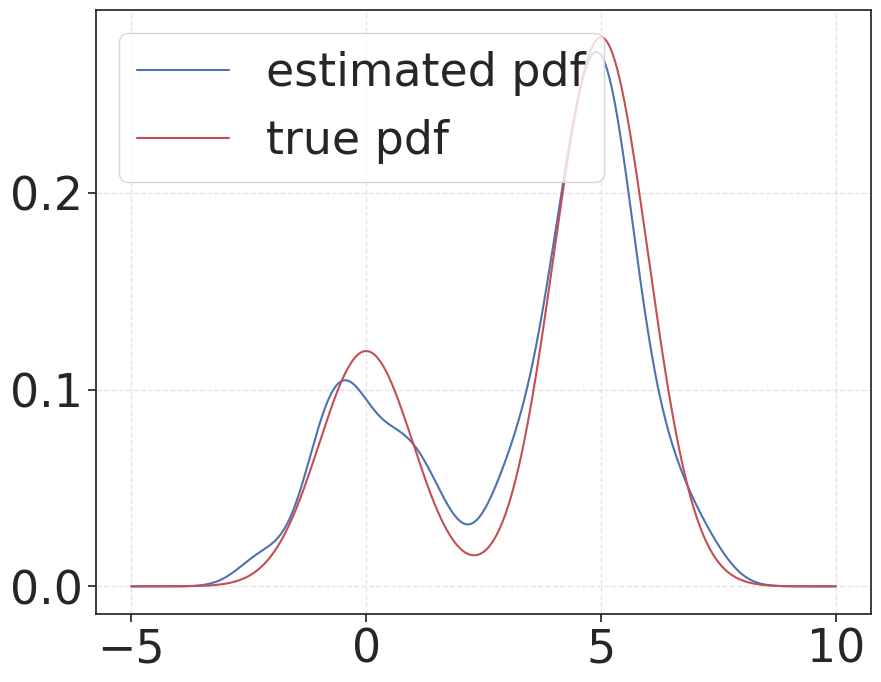

In [15]:
kde = KernelDensity(bandwidth=opt_bandwidth)
kde.fit(samples[:,None])
pdf = np.exp(kde.score_samples(x_values[:,None]))

plt.figure(figsize=(10, 8), dpi=100)
plt.plot(x_values, pdf, color='b', label='estimated pdf', zorder=2);
plt.plot(x_values, true_pdf, color='r', label='true pdf', zorder=2);
plt.legend();
plt.grid(which='both', linestyle='--', alpha=0.5);
plt.show()

# Задача 3. Непараметрическая регрессия

Формула Надарая-Ватсона:
\begin{gather*}
a(x;X, Y) = \frac{\sum_{i = 1}^n y_j K\left(\frac{\rho(x, x_j)}{h}\right)}{\sum_{j=1}^n K\left(\frac{\rho(x,x_j)}{h}\right)}
\end{gather*}

Оценка риска 
\begin{gather*}
\hat{J}(h) = \sum_{i = 1}^n (y_i - a(x_i;X_{(i)},Y_{(i)}))^2 = 
\sum_{i = 1}^{n} \left( y_i - \frac{\sum_{j} y_j K_{ij}}{\sum_{j}K_{ij}}\right)^{2} \cdot \left( 1 - \frac{K(0)}{\sum_{j=1}^n K_{ij}} \right)^{-2}.
\end{gather*}

In [16]:
class GaussianKernel:
    def __init__(self, loc=0, scale=1):
        self.loc = loc
        self.scale = scale
    def __call__(self, x):
        """
        Возвращает плотность распределение в точке x.
        """
        return stats.norm.pdf(x, loc=self.loc, scale=self.scale)

class NadarayaWatsonRegressor:
    def __init__(self, kernel, bandwidth):
        self.kernel = kernel
        self.bandwidth = bandwidth
    def fit(self, X, Y):
        self.X = X
        self.Y = Y
    def predict(self, X):
        K_X = (X[:,None] - self.X[None,:]) / self.bandwidth
        K = self.kernel(K_X)
        predictions = np.sum(K * self.Y[None, :], axis=1) / np.sum(K, axis=1)
        return predictions
    
def nw_regression_estimated_risk(X, Y, bandwidth, kernel=GaussianKernel()):
    h = bandwidth
    nw_regressor = NadarayaWatsonRegressor(GaussianKernel(), h)
    nw_regressor.fit(X, Y)
    Y_pred = nw_regressor.predict(X)
    K_X = (X.reshape((-1, 1)) - X.reshape((1, -1))) / h
    K = kernel(K_X)
    K_sums = np.sum(K, axis=1)
    J = np.sum((((Y - Y_pred) * K_sums) / (K_sums - kernel(0)))**2)
    return J

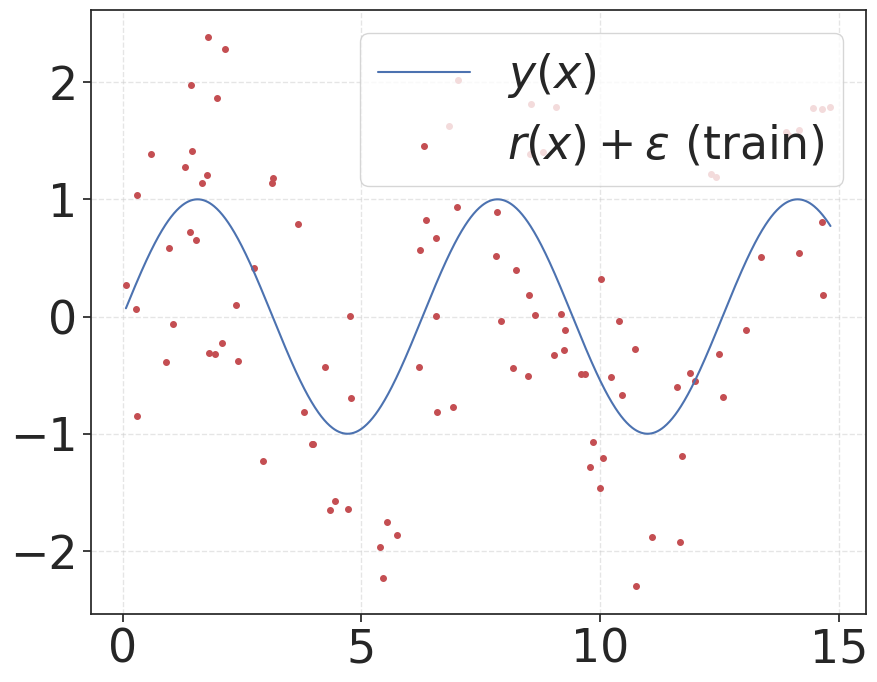

In [17]:
rng = np.random.RandomState(0)
X = 15 * rng.rand(100)
Y = np.sin(X).ravel()
Y += 3 * (0.5 - rng.rand(X.shape[0]))

x_values = np.linspace(X.min(), X.max(), num=1000)
y_values = np.sin(x_values)

plt.figure(figsize=(10, 8), dpi=100)
plt.plot(x_values, y_values, color='b', label='$y(x)$')
plt.scatter(X, Y, color='r', s=16, label=r'$r(x) + \varepsilon$ (train)')
plt.legend(loc='upper right');
plt.grid(which='both', linestyle='--', alpha=0.5);

In [18]:
permutation = np.argsort(X)
X = X[permutation]
Y = Y[permutation]

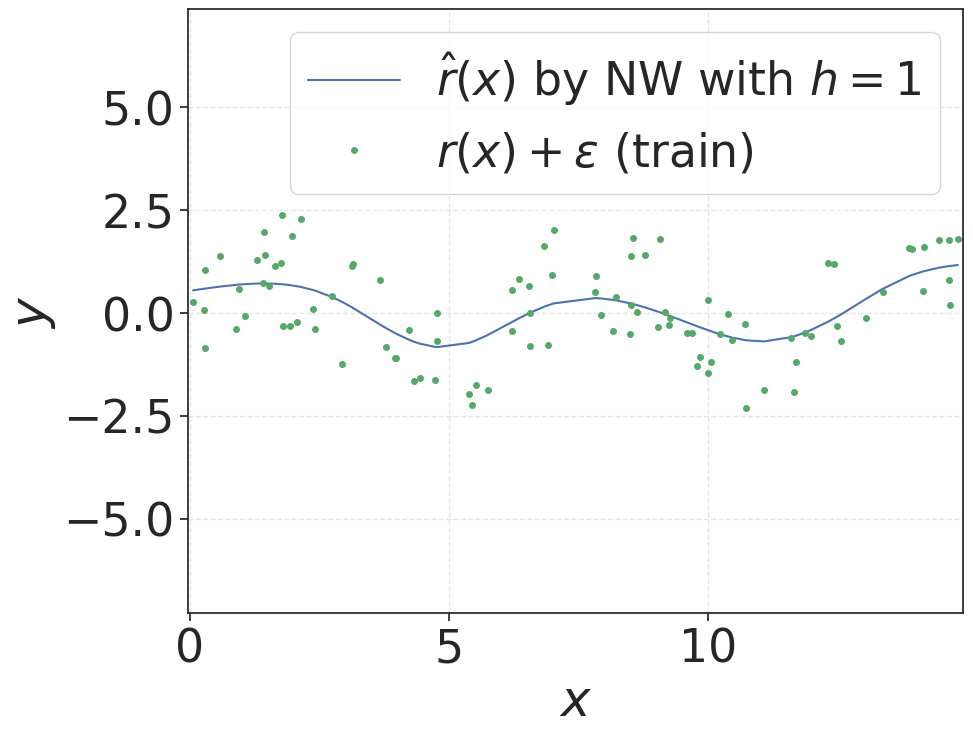

In [19]:
bandwidth = 1
nw_regressor = NadarayaWatsonRegressor(GaussianKernel(), bandwidth)
nw_regressor.fit(X, Y)
Y_pred = nw_regressor.predict(X)
plt.figure(figsize=(10, 8), dpi=100)
plt.plot(X, Y_pred, color='b', label='$\hat{{r}}(x)$ by NW with $h = {}$'.format(bandwidth), zorder=2)
plt.plot(X, Y, color='g', marker='o', markersize=4, linestyle='none', label=r'$r(x) + \varepsilon$ (train)',
         zorder=2)
plt.legend()
plt.xlabel('$x$'); plt.ylabel('$y$');
plt.xlim([X.min() - 0.1, X.max() + 0.1])
plt.ylim([Y.min() - 5, Y.max() + 5])
plt.grid(which='both', linestyle='--', alpha=0.5);
plt.show()

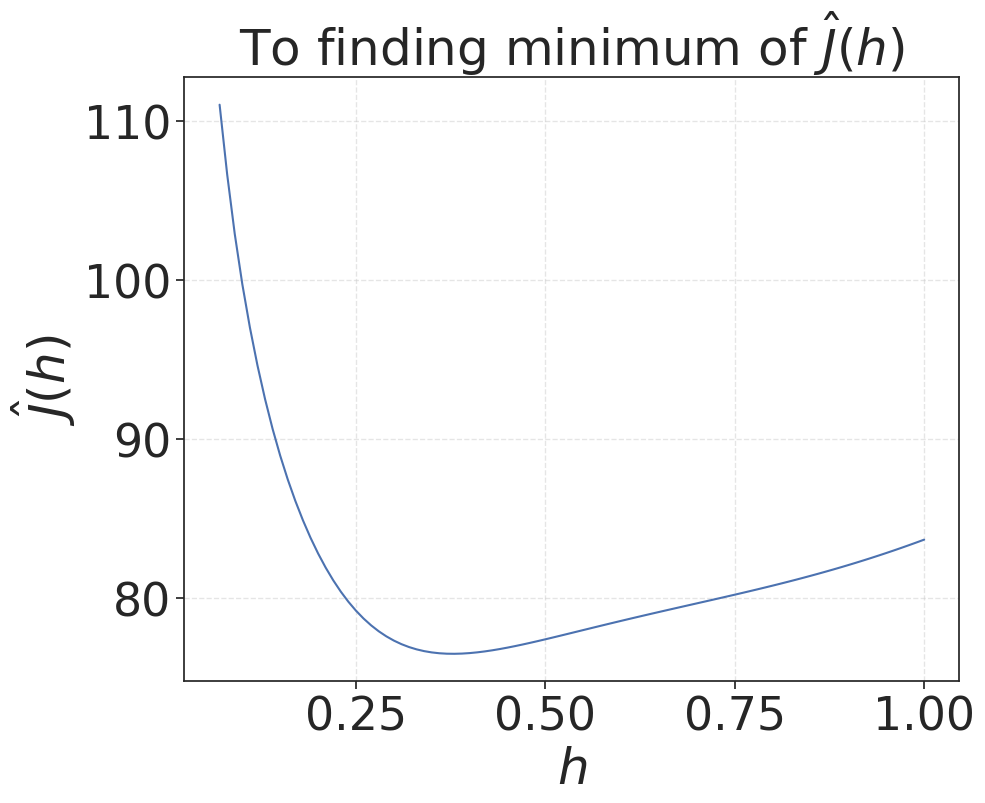

In [20]:
bandwidth_range = np.linspace(0.07, 1, 94)
risk_values = []
for h in bandwidth_range:
    risk_values.append(nw_regression_estimated_risk(X, Y, h))
risk_values = np.array(risk_values)
plt.figure(figsize=(10, 8), dpi=100)
plt.plot(bandwidth_range, risk_values, color='b', zorder=2)
plt.xlabel('$h$'); plt.ylabel(r'$\hat{J}(h)$');
plt.title(r'To finding minimum of $\hat{J}(h)$');
plt.grid(which='both', linestyle='--', alpha=0.5);
plt.show()

In [21]:
opt_bandwidth = bandwidth_range[np.argmin(risk_values)]
print("Minimal value of J(h) reached at point h = {}, J(h) = {}".format(opt_bandwidth, np.min(risk_values)))

Minimal value of J(h) reached at point h = 0.37999999999999995, J(h) = 76.5023581249331


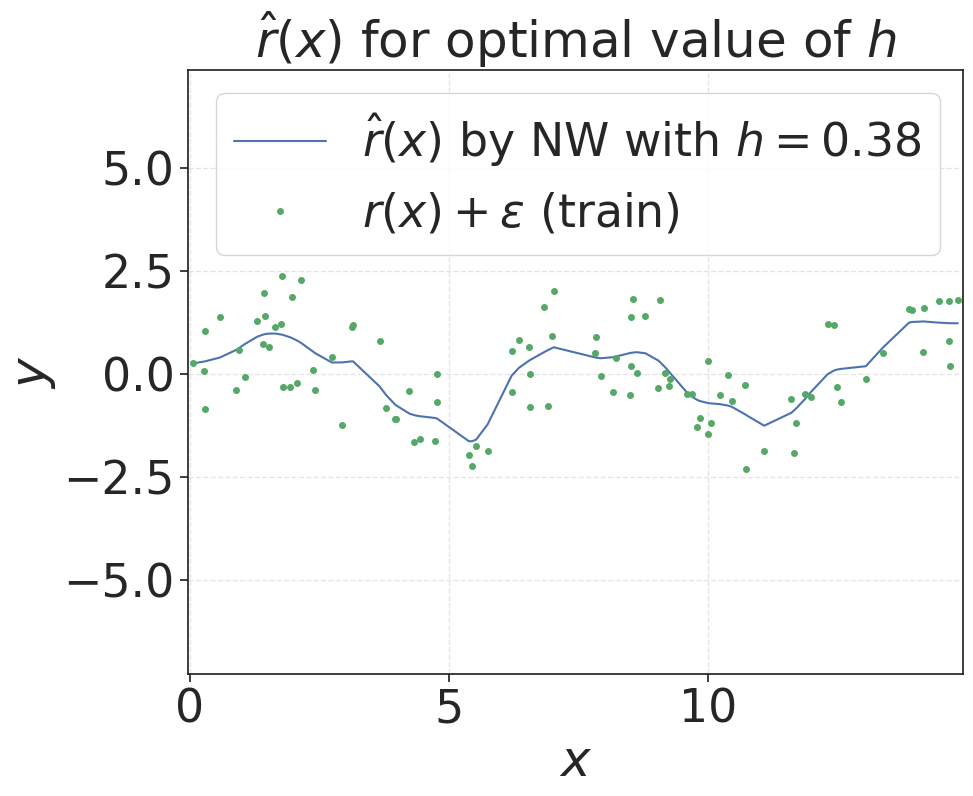

In [22]:
bandwidth = opt_bandwidth
nw_regressor = NadarayaWatsonRegressor(GaussianKernel(), bandwidth)
nw_regressor.fit(X, Y)
Y_pred = nw_regressor.predict(X)
plt.figure(figsize=(10, 8), dpi=100)
plt.plot(X, Y_pred, color='b',label=r'$\hat{{r}}(x)$ by NW with $h = {:.2}$'.format(bandwidth))
plt.plot(X, Y, color='g', marker='o', markersize=4, linestyle='none', label=r'$r(x) + \varepsilon$ (train)')
plt.legend()
plt.xlabel('$x$'); plt.ylabel('$y$');
plt.title(r'$\hat{r}(x)$ for optimal value of $h$')
plt.xlim([X.min() - 0.1, X.max() + 0.1])
plt.ylim([Y.min() - 5, Y.max() + 5])
plt.grid(which='both', linestyle='--', alpha=0.5);
plt.show()

## Построение доверительной трубки

\begin{gather*}
\hat{\sigma}^2 = \frac{1}{2 (n - 1)} \sum\limits_{i=1}^{n-1} \left( y_{i+1} - y_{i}  \right)
\end{gather*}


\begin{gather*}
w_i = \frac{K\left(\frac{x - X_i}{h}\right)}{\sum\limits_{j=1}^{n} K\left(\frac{x - X_j}{h}\right)}
\end{gather*}

Доверительная трубка:

\begin{gather*}
r_{\pm}(x) = a(x;X,Y) \pm z_{\alpha} \hat{\sigma} \sqrt{\sum\limits_{i=1}^{n} w_i^2}
\end{gather*}


\begin{gather*}
z_{\alpha} = \Phi^{-1}\left( \frac{1 + (1 - \alpha)^{\frac{h}{b - a}}}{2} \right)
\end{gather*}


In [23]:
alpha = 0.05
h = opt_bandwidth
n = len(Y)
a = np.min(X)
b = np.max(X)
m = (b - a) / h
q = stats.norm.ppf((1 + (1 - alpha) ** (1 / m)) / 2)
print('q =', q)
sigma = np.sqrt(np.sum((Y[1:] - Y[:-1]) ** 2)  / (2 * (n - 1)))
print('sigma =', sigma)

x_values = np.linspace(a, b, 400)
y_values = np.sin(x_values)

kernel = GaussianKernel()

# по формулам выше посчитаем дисперсию
K = kernel((x_values[:, None] - X[None, :]) / h)
W = K / K.sum(axis=1)[:, None]
se = sigma * np.sqrt(np.sum(W ** 2, axis=1))

nw_regressor = NadarayaWatsonRegressor(kernel, h)
nw_regressor.fit(X, Y)
Y_pred = nw_regressor.predict(x_values)

lower = Y_pred - q * se
upper = Y_pred + q * se

q = 3.211569851003454
sigma = 0.8487885374634165


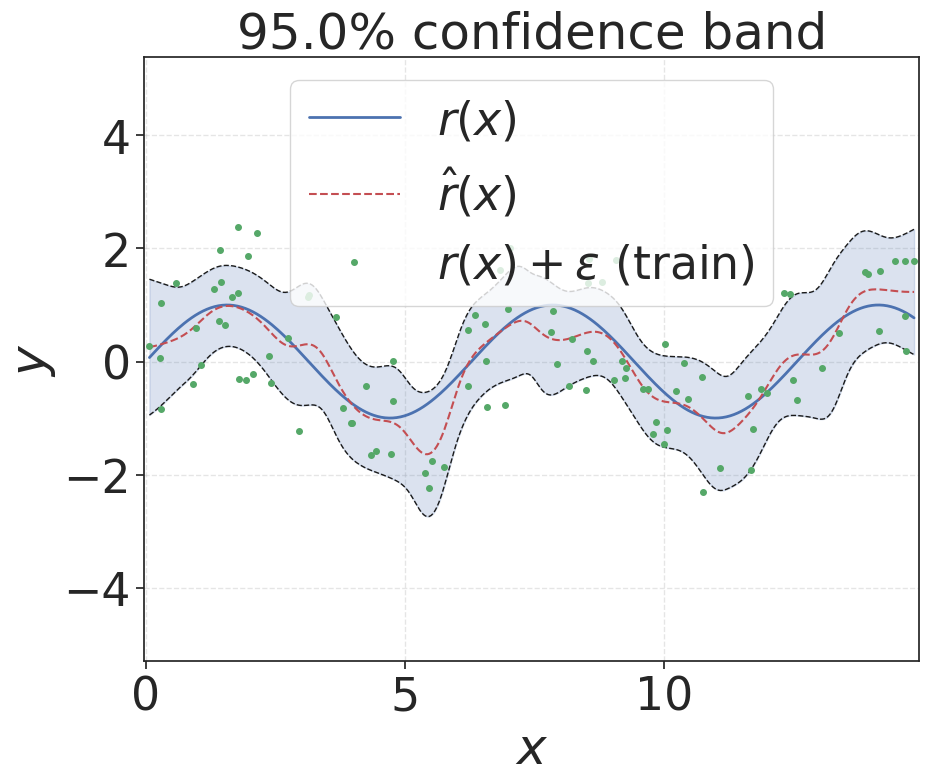

In [24]:
plt.figure(figsize=(10, 8), dpi=100)
plt.fill_between(x_values, lower, upper, color='b', alpha=0.2, zorder=1)
plt.plot(x_values, y_values, color='b', linestyle='-', linewidth=2, label=r'$r(x)$')
plt.plot(x_values, lower, color='k', linewidth=1, linestyle='--')
plt.plot(x_values, upper, color='k', linewidth=1, linestyle='--')
plt.plot(x_values, Y_pred, color='r', linestyle='--', label=r'$\hat{r}(x)$')
plt.plot(X, Y, color='g', marker='o', markersize=4, linestyle='none', label=r'$r(x) + \varepsilon$ (train)')
plt.xlabel('$x$'); plt.ylabel('$y$'); plt.title('{:.1f}% confidence band'.format(100 * (1 - alpha)))
plt.xlim([X.min() - 0.1, X.max() + 0.1])
plt.ylim([Y.min() - 3, Y.max() + 3])
plt.legend()
plt.grid(which='both', alpha=0.5, linestyle='--');
plt.show()

# Задача 4. KDE GAN

А сейчас мы сделаем GAN, но... без нейросеток!

Будем сэмплировать картинки из KDE ;)

In [25]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

In [26]:
# загрузим данные
digits = load_digits()
data = digits.data
print('Initial data shape: data.shape = {}'.format(data.shape))

Initial data shape: data.shape = (1797, 64)


In [27]:
# уменьшим размерность данных

pca = PCA(n_components=15, whiten=False)
data = pca.fit_transform(digits.data)
print('After dimensionality reduction: data.shape = {}'.format(data.shape))

After dimensionality reduction: data.shape = (1797, 15)


In [28]:
# прооптимизируем bandwidth с помощью GridSearch
params = {'bandwidth': np.logspace(-1, 1, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(data)

GridSearchCV(estimator=KernelDensity(),
             param_grid={'bandwidth': array([ 0.1       ,  0.1274275 ,  0.16237767,  0.20691381,  0.26366509,
        0.33598183,  0.42813324,  0.54555948,  0.6951928 ,  0.88586679,
        1.12883789,  1.43844989,  1.83298071,  2.33572147,  2.97635144,
        3.79269019,  4.83293024,  6.15848211,  7.8475997 , 10.        ])})

best bandwidth: 3.79269019073225


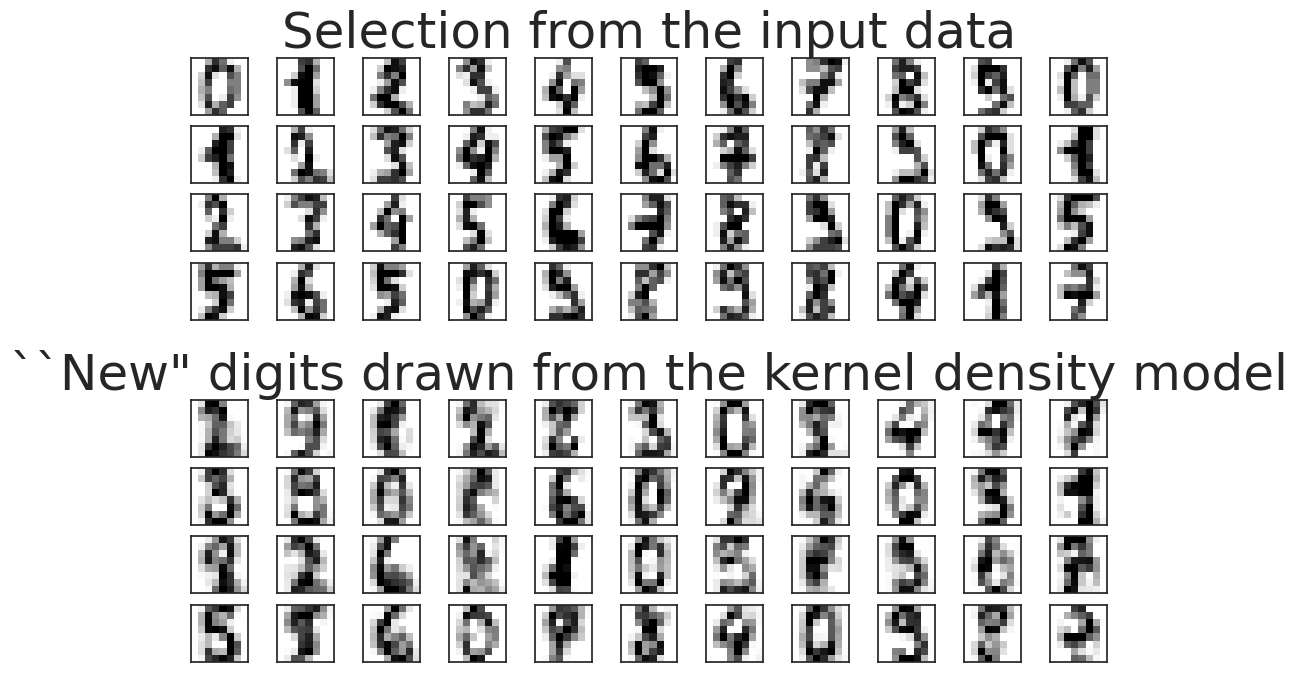

In [29]:
print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

kde = grid.best_estimator_

# просэмплируем новые циферки
new_data = kde.sample(44, random_state=0)
new_data = pca.inverse_transform(new_data)

new_data = new_data.reshape((4, 11, -1))
real_data = digits.data[:44].reshape((4, 11, -1))

# сравним как они выглядят2
fig, ax = plt.subplots(9, 11, subplot_kw=dict(xticks=[], yticks=[]), figsize=(12, 8), dpi=100)
for j in range(11):
    ax[4, j].set_visible(False)
    for i in range(4):
        im = ax[i, j].imshow(real_data[i, j].reshape((8, 8)),
                             cmap=plt.cm.binary, interpolation='nearest')
        im.set_clim(0, 16)
        im = ax[i + 5, j].imshow(new_data[i, j].reshape((8, 8)),
                                 cmap=plt.cm.binary, interpolation='nearest')
        im.set_clim(0, 16)

ax[0, 5].set_title('Selection from the input data')
ax[5, 5].set_title('``New" digits drawn from the kernel density model')

plt.show()